# Homework 3

Hi! Today you have a difficult task.
You need to implement two ideas to upgrade the metric learning pipeline: HardClusterSampler and HierarchicalTripletLoss.

In [1]:
# !pip install -U catalyst albumentations

In [2]:
from catalyst.utils import set_global_seed


set_global_seed(42)

# Metric Learning

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

## Omniglot

Remember dataset: [Omniglot](https://github.com/brendenlake/omniglot). It contains 1623 different handwritten characters from 50 different alphabets. They have been written by 20 different people and collect via Amazon's Mechanical Turk. Some of the characters are presented on the picture:

![photo](https://raw.githubusercontent.com/brendenlake/omniglot/master/omniglot_grid.jpg)

In [4]:
# Download dataset
# !git clone https://github.com/brendenlake/omniglot
# !unzip omniglot/python/images_background
# !unzip omniglot/python/images_evaluation

Look at the file structure. Each folder is called after alphabetic system and contains character's folder with drawn examples.

Let's show the `a` character from the Latin alphabet.

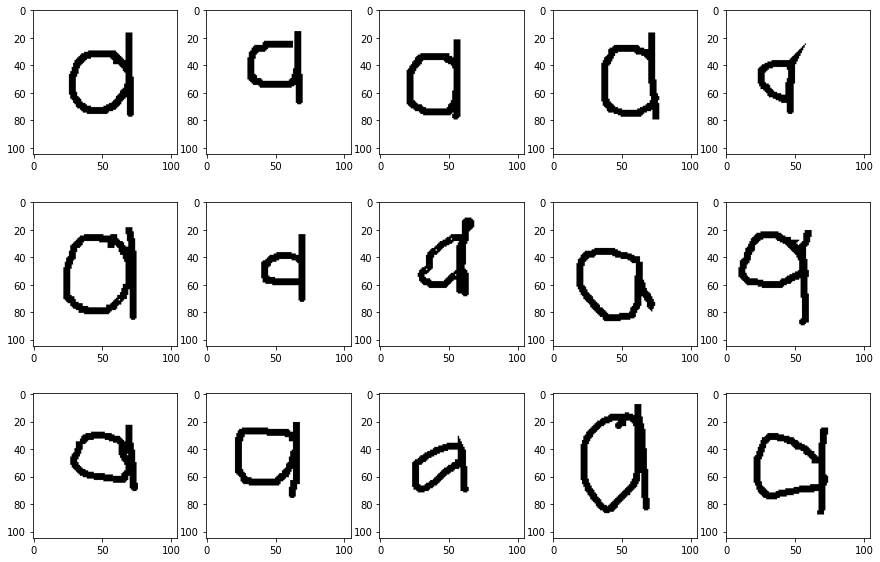

In [5]:
from pathlib import Path


latin_a = Path("images_background/Latin/character01")
paths = list(latin_a.glob("*.png"))

_, axs = plt.subplots(3, 5, figsize=(15, 10))

for i in range(15):
    image = Image.open(paths[i])
    axs[i % 3][i % 5].imshow(image)

We use `images_background` as train part of dataset and `images_evaluation` as valid part.

In [6]:
data = {
    "train": {"labels": [], "image_paths": [], "cls2label": {}, "root": Path("images_background")},
    "valid": {"labels": [], "image_paths": [], "cls2label": {}, "root": Path("images_evaluation")}
}

for part in data:
    cur_part = data[part]
    for alphabet_path in cur_part["root"].iterdir():
        for ch in alphabet_path.iterdir():
            cur_part["labels"].extend(f"{alphabet_path.name}_{ch.name}" for _ in ch.glob("*.png"))
            cur_part["image_paths"].extend(ch.glob("*.png"))
    
    cur_part["labels"] = np.array(cur_part["labels"])
    cur_part["image_paths"] = np.array(cur_part["image_paths"])
    cur_part["cls2label"] = {c: num for num, c in enumerate(np.unique(cur_part["labels"]))}

## Metric Learning Pipeline

Remember the Metric Learning pipeline in training stage

![training stage](https://miro.medium.com/max/1400/1*_kwjkuV7MtJCCYriwwo3uA.png)

and in validation stage 

![validating stage](https://miro.medium.com/max/1400/1*w3NVYqXA_e-EwWrvnvvrDw.png)


(from [Metric Learning with Catalyst](https://medium.com/pytorch/metric-learning-with-catalyst-8c8337dfab1a) by [@AlexeySh](https://github.com/AlekseySh))

To train model for Netric Learning objective, we need:

- Metric Learning Dataset for training
- Query/Gallery Dataset for validation
- In-batch sampler of triplets
- Triplet Loss criterion

We have implemented this. But you need to understand some parts of this pipeline.
That's why we left `HardTripletSampler` and `TripletMarginLossWithSampler`.

### Data Loaders

Metric Learning Dataset is similar with usual dataset. One difference is the `get_labels` method. It should return all labels in dataset. That used for class balanced batch sampler.

In [7]:
import torch
from catalyst.utils import imread
from catalyst.data import (
    MetricLearningTrainDataset,
    QueryGalleryDataset,
)
from torch.utils.data import Dataset


class OmniGlotMLDataset(MetricLearningTrainDataset):
    def __init__(
        self,
        images,
        targets,
        transform=None
    ):
        self.images = images
        self.targets = targets
        self.transform = transform
    
    def __getitem__(self, index):
        img, target = self.images[index], int(self.targets[index])
        img = imread(img)

        if self.transform is not None:
            img = self.transform(image=img)["image"].mean(0, keepdims=True)
        
        return img, target

    # The most important method!
    def get_labels(self):
        return self.targets.tolist()

    def __len__(self):
        return self.images.shape[0]

For validation, we need to create an Query-Gallery Dataset. Some of the object must be marked as query.

In [8]:
class OmniGlotQGDataset(QueryGalleryDataset):

    def __init__(
        self,
        images,
        targets,
        transform=None,
        gallery_fraq=0.2,
    ):
        self._omniglot = OmniGlotMLDataset(
            images=images, targets=targets, transform=transform
        )

        self._is_query = np.zeros(len(self._omniglot)).astype(bool)
        labels = np.array(self._omniglot.get_labels())
        self._query_size = 0
        # creating query/gallery partition
        for label in np.unique(targets):
            query_size = \
                np.ceil(np.sum(labels == label) * gallery_fraq).astype(int)
            # defining query size for current label
            idx = np.arange(len(self._omniglot))[labels == label]
            # indexes with current label
            assert len(idx) >= query_size
            
            query_idx = np.random.choice(idx, size=query_size, replace=False)
            # sampling query
            self._is_query[query_idx] = True
            # changing is_query flag
            self._query_size += query_size
            # incrementing query size

    def __getitem__(self, idx: int):
        image, label = self._omniglot[idx]
        return {
            "features": image,
            "targets": label,
            "is_query": self._is_query[idx],
        }

    def __len__(self):
        return len(self._omniglot)

    @property
    def gallery_size(self):
        return len(self._omniglot) - self._query_size

    @property
    def query_size(self):
        return self._query_size

We won't use augmentation in our pipeline. But the reason we'll use `albumentations` is that it has convinient tools for the image preprocessing. 

In [10]:
import albumentations as albu
from albumentations.pytorch import ToTensorV2 as ToTensor


IMAGE_SIZE = 32

transform = albu.Compose([
    albu.LongestMaxSize(IMAGE_SIZE),
    albu.PadIfNeeded(IMAGE_SIZE, IMAGE_SIZE, border_mode=0),
    albu.Rotate(limit=30),
    albu.Normalize(),
    ToTensor()
])

Process train/valid data, create datasets and loaders.

In [11]:
train_images = data["train"]["image_paths"]
train_labels = data["train"]["labels"]

indexes = np.arange(train_images.shape[0])
np.random.shuffle(indexes)
train_images = train_images[indexes]
train_targets = np.array([data["train"]["cls2label"][c] for c in train_labels])[indexes]

In [12]:
from torch.utils.data import DataLoader
from catalyst.data import BalanceBatchSampler

dataset_train = OmniGlotMLDataset(images=train_images, targets=train_targets, transform=transform)
sampler = BalanceBatchSampler(labels=dataset_train.get_labels(), p=64, k=16)
train_loader = DataLoader(dataset=dataset_train, sampler=sampler, batch_size=sampler.batch_size)

valid_images = data["valid"]["image_paths"]
valid_labels = data["valid"]["labels"]
valid_targets = np.array([data["valid"]["cls2label"][c] for c in valid_labels])

dataset_valid = OmniGlotQGDataset(images=valid_images, targets=valid_targets, transform=transform, gallery_fraq=0.2)
valid_loader = DataLoader(dataset=dataset_valid, batch_size=256)

### Training

In [13]:
from itertools import combinations, product
from random import sample, choices
from sys import maxsize

from catalyst.data import InBatchTripletsSampler
from catalyst.contrib.utils.misc import find_value_ids
from catalyst.data.utils import convert_labels2list
from catalyst.utils.torch import normalize


class HardTripletsSampler(InBatchTripletsSampler):
    """
    This sampler selects hardest triplets based on distances between features:
    the hardest positive sample has the maximal distance to the anchor sample,
    the hardest negative sample has the minimal distance to the anchor sample.
    Note that a typical triplet loss chart is as follows:
    1. Falling: loss decreases to a value equal to the margin.
    2. Long plato: the loss oscillates near the margin.
    3. Falling: loss decreases to zero.
    """

    def __init__(self, norm_required=False):
        """
        Args:
            norm_required: set True if features normalisation is needed
        """
        self._norm_required = norm_required

    def _sample(self, features, labels):
        """
        This method samples the hardest triplets inside the batch.
        Args:
            features: has the shape of [batch_size, feature_size]
            labels: labels of the samples in the batch
        Returns:
            the batch of the triplets in the order below:
            (anchor, positive, negative)
        """
        assert features.shape[0] == len(labels)

        if self._norm_required:
            features = normalize(samples=features.detach())

        dist_mat = torch.cdist(x1=features, x2=features, p=2)

        ids_anchor, ids_pos, ids_neg = self._sample_from_distmat(
            distmat=dist_mat, labels=labels
        )

        return ids_anchor, ids_pos, ids_neg

    @staticmethod
    def _sample_from_distmat(distmat, labels):
        """
        This method samples the hardest triplets based on the given
        distances matrix. It chooses each sample in the batch as an
        anchor and then finds the harderst positive and negative pair.
        Args:
            distmat: matrix of distances between the features
            labels: labels of the samples in the batch
        Returns:
            the batch of triplets in the order below:
            (anchor, positive, negative)
        """
        ids_all = set(range(len(labels)))

        ids_anchor, ids_pos, ids_neg = [], [], []

        for i_anch, label in enumerate(labels):
            ids_label = set(find_value_ids(it=labels, value=label))

            ids_pos_cur = np.array(list(ids_label - {i_anch}), int)
            ids_neg_cur = np.array(list(ids_all - ids_label), int)

            i_pos = ids_pos_cur[distmat[i_anch, ids_pos_cur].argmax()]
            i_neg = ids_neg_cur[distmat[i_anch, ids_neg_cur].argmin()]

            ids_anchor.append(i_anch)
            ids_pos.append(i_pos)
            ids_neg.append(i_neg)

        return ids_anchor, ids_pos, ids_neg

Torch has the TripletLoss criterion. But it doesn't work with in-batch sampler. We must join these two enteties in new one. It has to sample triplets by the given rule and calculate triplet loss with the margin.

In [14]:
import torch.nn as nn


class TripletMarginLossWithSampler(nn.Module):
    """
    This class combines in-batch sampling of triplets and
    default TripletMargingLoss from PyTorch.
    """

    def __init__(self, margin, sampler_inbatch):
        """
        Args:
            margin: margin value
            sampler_inbatch: sampler for forming triplets inside the batch
        """
        super().__init__()
        self._sampler_inbatch = sampler_inbatch
        self._triplet_margin_loss = nn.TripletMarginLoss(margin=margin)

    def forward(self, features, labels):
        """
        Args:
            features: features with the shape of [batch_size, features_dim]
            labels: labels of samples having batch_size elements
        Returns: loss value
        """
        labels_list = convert_labels2list(labels)

        (
            features_anchor,
            features_positive,
            features_negative,
        ) = self._sampler_inbatch.sample(features=features, labels=labels_list)

        loss = self._triplet_margin_loss(
            anchor=features_anchor,
            positive=features_positive,
            negative=features_negative,
        )
        return loss

Create simple model with pretrained MobileNet backbone. It's able to increase training time. Good model must be trained for long time (several hundreads epochs). For educational purposes, we adjust train time to one epoch.

In [15]:
from catalyst.contrib.nn import Normalize


def conv_block(in_feature, out_feature):
    return nn.Sequential(
        nn.Conv2d(in_feature, out_feature, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_feature),
        nn.Dropout(0.2),
        nn.ReLU(),
        nn.MaxPool2d(2, stride=2)
    )

model = nn.Sequential(
    conv_block(1, 4),
    conv_block(4, 8),
    conv_block(8, 16),
    conv_block(16, 32),
    conv_block(32, 64),
    nn.Flatten(),
    Normalize()
)

In [16]:
from catalyst import dl, utils
from catalyst.contrib.nn import TripletMarginLossWithSampler, RAdam


num_epochs = 300
lr = 1e-2

optimizer = RAdam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [100,])

sampler_inbatch = HardTripletsSampler()
criterion = TripletMarginLossWithSampler(margin=0.3, sampler_inbatch=sampler_inbatch)

callbacks = [
    dl.ControlFlowCallback(
        dl.CriterionCallback(), 
        loaders="train"
    ),
    dl.ControlFlowCallback(dl.CMCScoreCallback(topk_args=[1, 5, 10]), loaders="valid"),
    dl.PeriodicLoaderCallback(valid=10),
    dl.SchedulerCallback(),
]

In [17]:
runner = dl.SupervisedRunner(device=utils.get_device())
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    callbacks=callbacks,
    loaders={"train": train_loader, "valid": valid_loader},
    minimize_metric=False,
    verbose=True,
    valid_loader="valid",
    num_epochs=num_epochs,
    main_metric="cmc05",
)

1/300 * Epoch (train):   6% 1/16 [00:19<04:46, 19.13s/it, loss=0.621]

/home/adchumachenko/.local/lib/python3.6/site-packages/catalyst/contrib/nn/optimizers/radam.py:85: UserWarning:

This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)



1/300 * Epoch (train): 100% 16/16 [00:30<00:00,  1.92s/it, loss=0.599]
[2020-10-20 06:43:46,121] 
1/300 * Epoch 1 (_base): lr=0.0100 | momentum=0.9000
1/300 * Epoch 1 (train): cmc05=-inf | loss=0.6017
2/300 * Epoch (train):   0% 0/16 [00:00<?, ?it/s]

/home/adchumachenko/.local/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:396: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



2/300 * Epoch (train): 100% 16/16 [00:12<00:00,  1.28it/s, loss=0.523]
[2020-10-20 06:43:58,611] 
2/300 * Epoch 2 (_base): lr=0.0100 | momentum=0.9000
2/300 * Epoch 2 (train): cmc05=-inf | loss=0.5527
3/300 * Epoch (train): 100% 16/16 [00:12<00:00,  1.27it/s, loss=0.462]
[2020-10-20 06:44:11,197] 
3/300 * Epoch 3 (_base): lr=0.0100 | momentum=0.9000
3/300 * Epoch 3 (train): cmc05=-inf | loss=0.5130
4/300 * Epoch (train): 100% 16/16 [00:12<00:00,  1.25it/s, loss=0.469]
[2020-10-20 06:44:23,960] 
4/300 * Epoch 4 (_base): lr=0.0100 | momentum=0.9000
4/300 * Epoch 4 (train): cmc05=-inf | loss=0.4916
5/300 * Epoch (train): 100% 16/16 [00:12<00:00,  1.28it/s, loss=0.413]
[2020-10-20 06:44:36,454] 
5/300 * Epoch 5 (_base): lr=0.0100 | momentum=0.9000
5/300 * Epoch 5 (train): cmc05=-inf | loss=0.4783
6/300 * Epoch (train): 100% 16/16 [00:12<00:00,  1.26it/s, loss=0.445]
[2020-10-20 06:44:49,133] 
6/300 * Epoch 6 (_base): lr=0.0100 | momentum=0.9000
6/300 * Epoch 6 (train): cmc05=-inf | loss=0.

# Now try to implement sampler and loss by yourself!

## Hard Cluster Triplet Sampler

**tl;dr**

The target is to minimise intra class variations and to maximize the inter class variations.

First of all we counting "centroids" of a class:
$$
f_{i}^{m}=\frac{\sum^{K} f(x)}{K}
$$

then we are counting intra class loss:
$$
d_{i}^{i n t r a}=\max _{K}\left\|f(x)-f_{i}^{m}\right\|_{2}^{2}
$$
and inter class loss:
$$
d_{i}^{\text {inter}}=\min _{\forall i_{d} \in P, i_{d} \neq i}\left\|f_{i}^{m}-f_{i_{d}}^{m}\right\|_{2}^{2}
$$

The final loss is:
$$
L b_{c}=\sum_{i}^{P} \max \left(\left(d_{i}^{i n t r a}-d_{i}^{i n t e r}+\alpha\right), 0\right)
$$



[article](https://arxiv.org/abs/1812.10325)

In [ ]:
from catalyst.data import IInbatchTripletSampler

class HardClusterTripletsSampler(IInbatchTripletSampler):
    
    def __init__(self):
        # Initialize everything you need
        pass

    def sample(self, features, labels):
        # Sample object for Triplet Loss.
        # May be you need mean vectors for each cluster(label)
        pass

In [ ]:
num_epochs = 300
lr = 1e-2

model = nn.Sequential(
    conv_block(1, 4),
    conv_block(4, 8),
    conv_block(8, 16),
    conv_block(16, 32),
    conv_block(32, 64),
    nn.Flatten(),
    Normalize()
)
optimizer = RAdam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [100,])

sampler_inbatch = HardClusterTripletsSampler()
criterion = TripletMarginLossWithSampler(margin=0.3, sampler_inbatch=sampler_inbatch)

callbacks = [
    dl.ControlFlowCallback(
        dl.CriterionCallback(), 
        loaders="train"
    ),
    dl.ControlFlowCallback(dl.CMCScoreCallback(topk_args=[1, 5, 10]), loaders="valid"),
    dl.PeriodicLoaderCallback(valid=10),
    dl.SchedulerCallback(),
]

In [ ]:
runner = dl.SupervisedRunner(device=utils.get_device())
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    callbacks=callbacks,
    loaders={"train": train_loader, "valid": valid_loader},
    minimize_metric=False,
    verbose=True,
    valid_loader="valid",
    num_epochs=num_epochs,
    main_metric="cmc05",
)

## Hierarchical Triplet Loss

![](https://cdn.mathpix.com/snip/images/1TyIaVSJSOgWcwLS62bmsMFJTG5rDGKYjUVqRDdZi3w.original.fullsize.png)

Here we will construct hierarchical structure of classes based on the computed interclass distances.

So the algoruthm looks like:

![](https://cdn.mathpix.com/snip/images/pYM4D0nkTjPxRpMWzOth3Duxnyj8sKdLpU4xXmeu7SQ.original.fullsize.png)

You can try to build a tree in a way that every leaf represents a letter and every root of this leaf represents an alphabet.
In this case, your tree has a depth of 3. Also, you can skip the step with updating the tree.


[article](https://arxiv.org/pdf/1810.06951.pdf)

In [ ]:
from torch.nn.functional import triplet_margin_loss


class HierarchicalTripletMarginLossWithSampler(nn.Module):
    """
    This class combines in-batch sampling of triplets and
    default TripletMargingLoss from PyTorch.
    """

    def __init__(self, sampler_inbatch):
        """
        Args:
            margin: margin value
            sampler_inbatch: sampler for forming triplets inside the batch
        """
        super().__init__()
        self._sampler_inbatch = sampler_inbatch
        self._triplet_margin_loss = triplet_margin_loss

    def forward(self, features, labels):
        """
        Args:
            features: features with the shape of [batch_size, features_dim]
            labels: labels of samples having batch_size elements
        Returns: loss value
        """
        labels_list = convert_labels2list(labels)

        (
            features_anchor,
            features_positive,
            features_negative,
        ) = self._sampler_inbatch.sample(features=features, labels=labels_list)
        
        margin = ... # Calculate margin based on label

        loss = self._triplet_margin_loss(
            anchor=features_anchor,
            positive=features_positive,
            negative=features_negative,
            margin=margin
        )
        return loss

In [ ]:
num_epochs = 300
lr = 1e-2

model = nn.Sequential(
    conv_block(1, 4),
    conv_block(4, 8),
    conv_block(8, 16),
    conv_block(16, 32),
    conv_block(32, 64),
    nn.Flatten(),
    Normalize()
)
optimizer = RAdam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [100,])

sampler_inbatch = HardTripletsSampler()
criterion = HierarchicalTripletMarginLossWithSampler(sampler_inbatch=sampler_inbatch)

callbacks = [
    dl.ControlFlowCallback(
        dl.CriterionCallback(), 
        loaders="train"
    ),
    dl.ControlFlowCallback(dl.CMCScoreCallback(topk_args=[1, 5, 10]), loaders="valid"),
    dl.PeriodicLoaderCallback(valid=10),
    dl.SchedulerCallback(),
]

In [ ]:
runner = dl.SupervisedRunner(device=utils.get_device())
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    callbacks=callbacks,
    loaders={"train": train_loader, "valid": valid_loader},
    minimize_metric=False,
    verbose=True,
    valid_loader="valid",
    num_epochs=num_epochs,
    main_metric="cmc05",
)

### Optional Task
If you implemented all methods quickly and sure about correctness, you can try to compare three methods.
But it takes time and resources to compare the methods properly.

< results >